<a href="https://colab.research.google.com/github/RenanMirandaLucas/StockBuySellAlert/blob/main/Juntando_m%C3%A9dia_m%C3%B3vel%2C_RSI%2C_MACD_e_bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


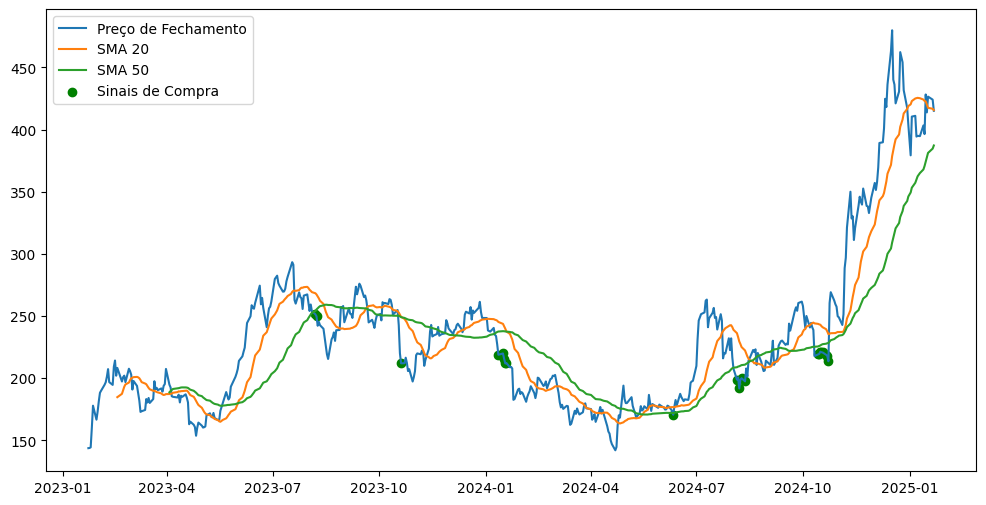

In [ ]:
!pip install ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta as ta

# Baixando os dados
ticker = "TSLA"  # Substitua pelo ticker desejado
df = yf.download(ticker, period="2y")

def calculate_rsi(data, period=14):
  """Calcula o Índice de Força Relativa (RSI).

  Args:
    data: Série de preços de fechamento.
    period: Período para o cálculo do RSI.

  Returns:
    Série com os valores do RSI.
  """
  delta = data.diff()
  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)
  avg_gain = gain.rolling(window=period).mean()
  avg_loss = loss.rolling(window=period).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1 + rs))
  return rsi

def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
  """Calcula a Média Móvel de Convergência e Divergência (MACD).

  Args:
    data: Série de preços de fechamento.
    fast_period: Período para a média móvel rápida.
    slow_period: Período para a média móvel lenta.
    signal_period: Período para a linha de sinal.

  Returns:
    Tupla com as séries MACD, sinal e histograma.
  """
  ema_fast = data.ewm(span=fast_period, adjust=False).mean()
  ema_slow = data.ewm(span=slow_period, adjust=False).mean()
  macd = ema_fast - ema_slow
  signal = macd.ewm(span=signal_period, adjust=False).mean()
  hist = macd - signal
  return macd, signal, hist

# ... (implementação das Bandas de Bollinger)

def calculate_bollinger_bands(data, window=20, k=2):
  """Calcula as Bandas de Bollinger.

  Args:
    data: Série de preços de fechamento.
    window: Período para o cálculo da média móvel e do desvio padrão.
    k: Multiplicador do desvio padrão para determinar a largura das bandas.

  Returns:
    DataFrame com as colunas 'bb_upper', 'bb_middle' e 'bb_lower'.
  """

  # Média móvel simples
  middle_band = data.rolling(window=window).mean()

  # Desvio padrão
  std = data.rolling(window=window).std()

  # Bandas superior e inferior
  upper_band = middle_band + k * std
  lower_band = middle_band - k * std

  return pd.DataFrame({'upper': upper_band.squeeze(), 'middle': middle_band.squeeze(), 'lower': lower_band.squeeze()}, index=data.index)

# Aplicando as funções ao DataFrame
#df['rsi'] = calculate_rsi(df['close'])
#df['macd'], df['signal'], df['hist'] = calculate_macd(df['close'])
# ... (aplicar a função das Bandas de Bollinger)

# Calculando os indicadores
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['MACD'], df['MACD_signal'], df['MACD_hist'] = calculate_macd(df['Close'])
df['RSI'] = calculate_rsi(df['Close'])

# Calculate Bollinger Bands and ensure index alignment
bollinger_bands_df = calculate_bollinger_bands(df['Close'])
# Reindex the Bollinger Bands DataFrame to match the original DataFrame's index
bollinger_bands_df = bollinger_bands_df.reindex(df.index)

# Assign Bollinger Bands columns to the original DataFrame
df['upper'] = bollinger_bands_df['upper'].values
df['middle'] = bollinger_bands_df['middle'].values
df['lower'] = bollinger_bands_df['lower'].values

# Definindo as condições de compra usando NumPy
buy_conditions = [
    df['SMA_20'] > df['SMA_50'],
    #df['MACD'] > df['MACD_signal'],
    df['RSI'] < 30,
    # Align 'Close' and 'lower' before comparison using the same index and forward fill NaN values
    #df['Close'] >= df['lower'].ffill()
]

# Combinando as condições usando a função np.all
df['buy_signal'] = np.all(buy_conditions, axis=0)

# Visualizando os resultados
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Preço de Fechamento')
plt.plot(df['SMA_20'], label='SMA 20')
plt.plot(df['SMA_50'], label='SMA 50')
plt.scatter(df.index[df['buy_signal'] == 1], df['Close'][df['buy_signal'] == 1], color='green', label='Sinais de Compra')
plt.legend()
plt.show()